In [1]:
# note: fdfdpy_OO must be in your JUPYTER_PATH for this import to work (or you can manually add it to path with some google=able code.)
from FDFD.Fdfd import Fdfd
import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
omega = 5e14                # angular frequency (2pi)
dl = 1e-7                   # grid size (m)
eps_r = np.ones((100,100))  # relative permittivity
eps_r[40:60, 40:60] = 5     # define box
NPML = [10, 10]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')

In [3]:
# sets simulation variables, constructs system matrix 'A', stored in 'simulation' object
simulation = Fdfd(omega,eps_r,dl,NPML,pol)

In [4]:
# set source and solve for electromagnetic fields
b = np.zeros((simulation.Nx,simulation.Ny))
b[40:60,30] = 1
(Hx,Hy,Ez) = simulation.solve_fields(b)

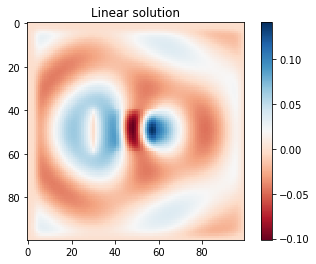

In [5]:
# plot
plt.imshow(np.real(Ez), cmap='RdBu')
plt.colorbar()
plt.title('Linear solution')

In [158]:
n2 = 20                           # Nonlinearity strength
nl_region = np.zeros(eps_r.shape)  # Nonliearity region
nl_region[40:60, 40:60] = 1
Nstep = 100                         # Number of steps for iterative solution

In [163]:
# Solve using the "Born" iteration

# Solve one more time the linear problem in case you're re-running cells
simulation = Fdfd(omega,eps_r,dl,NPML,pol)
(Hx,Hy,Ez) = simulation.solve_fields(b)

# Store convergence parameters
conv_param = np.zeros((Nstep, 1))

# Solve iteratively
for istep in range(0, Nstep):
    Eprev = Ez
    eps_nl = eps_r + n2*np.square(np.abs(Eprev))*nl_region
    simulation = Fdfd(omega,eps_nl,dl,NPML,pol)
    (Hx,Hy,Ez) = simulation.solve_fields(b)
    conv_param[istep] = np.linalg.norm(Ez - Eprev)/np.linalg.norm(Ez)

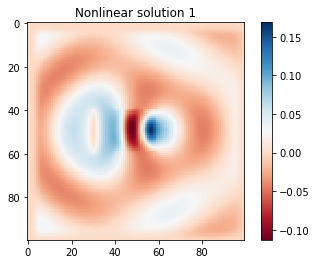

In [164]:
# plot
plt.imshow(np.real(Ez), cmap='RdBu')
plt.colorbar()
plt.title('Nonlinear solution 1')

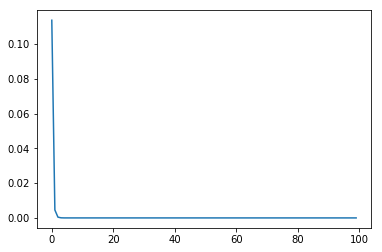

In [165]:
# Plot the convergence parameter
plt.plot(range(0, Nstep), conv_param)

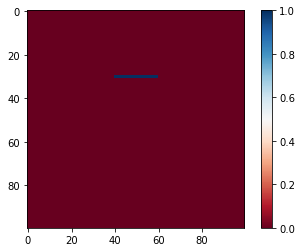

In [166]:
# Check visually if A(Ez)Ez looks like b
eps_nl = eps_r + n2*np.square(np.abs(Ez))*nl_region
simulation = Fdfd(omega,eps_nl,dl,NPML,pol)
temp = simulation.A.dot(Ez.ravel(order = 'F'))
temp = temp.reshape(simulation.Nx, simulation.Ny)
plt.imshow(np.abs(temp), cmap='RdBu')
plt.colorbar()

In [159]:
# Solve using the Newton method

# Solve one more time the linear problem in case you're re-running cells
simulation = Fdfd(omega,eps_r,dl,NPML,pol)
(Hx,Hy,Ez) = simulation.solve_fields(b)
Nbig = simulation.Nx*simulation.Ny

# Store convergence parameters
conv_param = np.zeros((Nstep, 1))

# Solve iteratively
for istep in range(0, Nstep):
    Eprev = Ez
    eps_nl = eps_r + n2*np.square(np.abs(Eprev))*nl_region
    simulation = Fdfd(omega,eps_nl,dl,NPML,pol)
    Anl = simulation.A 
    Aeb = Anl.dot(Eprev.ravel(order='F')) - b.ravel(order='F')
    Jac = Anl + sp.spdiags((n2*np.square(np.abs(Eprev))*nl_region).ravel(order='F'), 0, Nbig, Nbig, format='csc')
    # Note: I'm phrasing Newton's method as a linear problem to avoid inverting the Jacobian
    # Namely, J*(x_n - x_{n-1}) = -f(x_{n-1}), where J = df/dx(x_{n-1})
    Ediff = sp.linalg.spsolve(Jac, Aeb)
    Ez = Eprev - Ediff.reshape(simulation.Nx, simulation.Ny, order = 'F')
    conv_param[istep] = np.linalg.norm(Ez - Eprev)/np.linalg.norm(Ez)

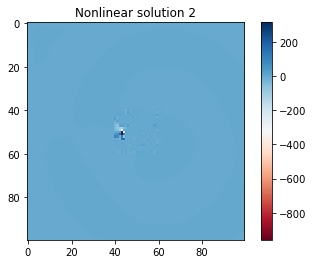

In [160]:
# plot
plt.imshow(np.real(Ez), cmap='RdBu')
plt.colorbar()
plt.title('Nonlinear solution 2')

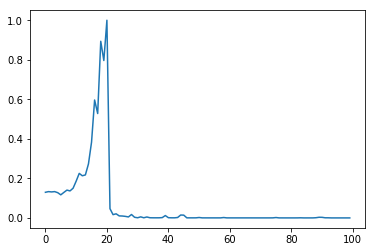

In [161]:
# Plot the convergence parameter
plt.plot(range(0, Nstep), conv_param)

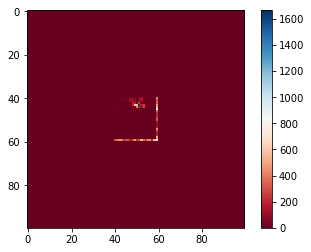

In [162]:
# Check visually if A(Ez)Ez looks like b
eps_nl = eps_r + n2*np.square(np.abs(Ez))*nl_region
simulation = Fdfd(omega,eps_nl,dl,NPML,pol)
temp = simulation.A.dot(Ez.ravel(order = 'F'))
temp = temp.reshape(simulation.Nx, simulation.Ny)
plt.imshow(np.abs(temp), cmap='RdBu')
plt.colorbar()